# Load Dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

In [2]:
# Import dataset
df = pd.read_csv('/content/Sales Data Fsd Mart.csv')
df = df[['Date', 'Day', 'Sale']]
df.head()

,Date,Day,Sale
0,01-Mar-24,FRIDAY,219791
1,02-Mar-24,SATURDAY,381272
2,03-Mar-24,SUNDAY,296996
3,04-Mar-24,MONDAY,306301
4,05-Mar-24,TUESDAY,408853


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    202 non-null    object
 1   Day     202 non-null    object
 2   Sale    202 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 4.9+ KB


# Cek Distribusi

In [4]:
df.describe()

,Sale
count,202.000000
mean,283878.628713
std,108061.354420
min,104501.000000
25%,220562.750000
50%,264326.500000
75%,310900.000000
max,949554.000000


In [5]:
df.describe(include='object')

,Date,Day
count,202,202
unique,202,7
top,18-Sep-24,FRIDAY
freq,1,29


In [6]:
df[['Date']] = df[['Date']].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    202 non-null    datetime64[ns]
 1   Day     202 non-null    object        
 2   Sale    202 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ KB


<ipython-input-6-1a3b04c30512>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[['Date']] = df[['Date']].apply(pd.to_datetime)


In [7]:
df[:20]

,Date,Day,Sale
0,2024-03-01,FRIDAY,219791
1,2024-03-02,SATURDAY,381272
2,2024-03-03,SUNDAY,296996
3,2024-03-04,MONDAY,306301
4,2024-03-05,TUESDAY,408853
5,2024-03-06,WEDNESDAY,290948
6,2024-03-07,THURSDAY,293711
7,2024-03-08,FRIDAY,423443
8,2024-03-09,SATURDAY,464966
9,2024-03-10,SUNDAY,617674


# Data Preparation

In [8]:
# Mengubah menjadi windows format berdasarkan teori pada time series data
def prepare_train_df(data_series, data_input=6):
    X, y = [], []

    for i in range(len(data_series) - data_input):
        X.append(data_series[i:i + data_input].values)
        y.append(data_series[i + data_input])

    X_df = pd.DataFrame(X, columns=[f'x{i+1}' for i in range(data_input)])
    y_df = pd.Series(y, name='y')

    train_df = pd.concat([X_df, y_df], axis=1)

    return train_df

data_series = df['Sale']
train_df = prepare_train_df(data_series, data_input=6)
train_df

,x1,x2,x3,x4,x5,x6,y
0,219791,381272,296996,306301,408853,290948,293711
1,381272,296996,306301,408853,290948,293711,423443
2,296996,306301,408853,290948,293711,423443,464966
3,306301,408853,290948,293711,423443,464966,617674
4,408853,290948,293711,423443,464966,617674,710859
...,...,...,...,...,...,...,...
191,281862,221824,228454,203174,282937,165445,237814
192,221824,228454,203174,282937,165445,237814,308632
193,228454,203174,282937,165445,237814,308632,255651
194,203174,282937,165445,237814,308632,255651,284303


# Data Prepocessing

In [9]:
# Split data, gunakan 10 baris terakhir sebagai testing data
train_data = train_df[:-10]
test_data = train_df[-10:]

# Pisahkan fitur (X) dan target (y)
X_train = train_data.drop(columns='y')
y_train= train_data['y']

#Pisahkan pada data testing
X_test = test_data.drop(columns='y')
y_test = test_data['y']

# print("Training Data :")
print("\nTesting Data (test_data):")
X_test


Testing Data (test_data):


,x1,x2,x3,x4,x5,x6
186,269059,342540,371018,298523,321005,281862
187,342540,371018,298523,321005,281862,221824
188,371018,298523,321005,281862,221824,228454
189,298523,321005,281862,221824,228454,203174
190,321005,281862,221824,228454,203174,282937
191,281862,221824,228454,203174,282937,165445
192,221824,228454,203174,282937,165445,237814
193,228454,203174,282937,165445,237814,308632
194,203174,282937,165445,237814,308632,255651
195,282937,165445,237814,308632,255651,284303


# Modelling GA-Regressi

In [10]:
np.random.seed(3)

# Parameter Algoritma Genetika
population_size = 20
num_generations = 1000
mutation_rate = 0.1
threshold_mape = 0.05
num_parents = int(0.5 * population_size)

# Algoritma Genetik + Regresi Multilinear
class LinearGA:
    def __init__(self, population_size, mutation_rate, num_parents):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.num_parents = num_parents
        self.population = None
        self.best_mape_per_generation = []

    def initialize_population(self, num_features):
        self.population = np.random.rand(self.population_size, num_features + 1)

    def fitness_function(self, X, y, population):
        mape_scores = []
        for individual in population:
            intercept = individual[0]
            coefficients = individual[1:]
            y_pred = X.dot(coefficients) + intercept
            mape = mean_absolute_percentage_error(y, y_pred)
            mape_scores.append(mape)
        return np.array(mape_scores)

    def select_parents(self, population, fitness):
        parents_idx = np.argsort(fitness)[:self.num_parents]
        return population[parents_idx]

    def crossover(self, parents):
        offspring = np.empty((self.population_size - self.num_parents, parents.shape[1]))
        for i in range(offspring.shape[0]):
            parent1_idx = i % parents.shape[0]
            parent2_idx = (i + 1) % parents.shape[0]
            crossover_point = np.random.randint(1, parents.shape[1])
            offspring[i, :crossover_point] = parents[parent1_idx, :crossover_point]
            offspring[i, crossover_point:] = parents[parent2_idx, crossover_point:]
        return offspring

    def mutate(self, offspring):
        for i in range(offspring.shape[0]):
            for j in range(offspring.shape[1]):
                if np.random.rand() < self.mutation_rate:
                    offspring[i, j] += np.random.uniform(-1, 1)
        return offspring

    def optimize(self, X, y):
        num_features = X.shape[1]
        self.initialize_population(num_features)

        for generation in range(num_generations):
            fitness = self.fitness_function(X, y, self.population)
            best_mape = np.min(fitness)
            best_chromosome = self.population[np.argmin(fitness)]
            self.best_mape_per_generation.append(best_mape)

            if (generation + 1) % 1000 == 0 or generation == 0:
                print(f"\nGeneration {generation + 1}:")

                data = {
                    'Chromosome': [list(chromosome) for chromosome in self.population],
                    'Fitness (MAPE)': fitness
                }
                df = pd.DataFrame(data)
                html_output = df.to_html(index=False)
                display(HTML(html_output))

                print(f"\nBest chromosome in generation {generation + 1}: {best_chromosome}")
                print(f"Best MAPE = {best_mape}")

            if best_mape < threshold_mape:
                print("Optimal solution found based on MAPE threshold.")
                break

            parents = self.select_parents(self.population, fitness)

            offspring = self.crossover(parents)
            offspring = self.mutate(offspring)
            self.population[:self.num_parents] = parents
            self.population[self.num_parents:] = offspring

        best_idx = np.argmin(fitness)
        best_solution = self.population[best_idx]
        intercept = best_solution[0]
        coefficients = best_solution[1:]
        return intercept, coefficients, best_mape

    def plot_performance(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.best_mape_per_generation, label='Best MAPE per Generation')
        plt.xlabel('Generation')
        plt.ylabel('MAPE')
        plt.title('Model Performance Over Generations')
        plt.legend()
        plt.grid(True)
        plt.show()

In [11]:
X_train = train_data.drop(columns='y').values
y_train = train_data['y'].values
X_test = test_data.drop(columns='y').values
y_test = test_data['y'].values

print("Training Data :")
print(X_train)
print("\nValidation Data :")
print(X_test)

Training Data :
[[219791 381272 296996 306301 408853 290948]
 [381272 296996 306301 408853 290948 293711]
 [296996 306301 408853 290948 293711 423443]
 ...
 [326544 492061 361765 269059 342540 371018]
 [492061 361765 269059 342540 371018 298523]
 [361765 269059 342540 371018 298523 321005]]

Validation Data :
[[269059 342540 371018 298523 321005 281862]
 [342540 371018 298523 321005 281862 221824]
 [371018 298523 321005 281862 221824 228454]
 [298523 321005 281862 221824 228454 203174]
 [321005 281862 221824 228454 203174 282937]
 [281862 221824 228454 203174 282937 165445]
 [221824 228454 203174 282937 165445 237814]
 [228454 203174 282937 165445 237814 308632]
 [203174 282937 165445 237814 308632 255651]
 [282937 165445 237814 308632 255651 284303]]


# Fitting model Regresi Multilinear

In [12]:
np.random.seed(3)
ga_model = LinearGA(population_size, mutation_rate, num_parents)
intercept, coefficients, best_mape = ga_model.optimize(X_train, y_train)
print("\nOptimized coefficients:", coefficients)
print("Optimized intercept:", intercept)
# print("Best MAPE:", best_mape)


Generation 1:


Chromosome,Fitness (MAPE)
"[0.5507979025745755, 0.7081478226181048, 0.2909047389129443, 0.510827605197663, 0.8929469543476547, 0.8962930889334381, 0.12558531046383625]",2.746209
"[0.20724287813818676, 0.05146720330082988, 0.44080984365063647, 0.029876210878566956, 0.4568332243947111, 0.6491440476147607, 0.2784872826479753]",1.084345
"[0.6762549019801313, 0.5908628174163508, 0.023981882377165364, 0.558854087990882, 0.2592524469074654, 0.41510119701006964, 0.28352508177131874]",1.326776
"[0.6931379183129963, 0.4404537176707395, 0.15686773847496327, 0.5446490180318447, 0.780314764511367, 0.30636353237617975, 0.2219578839321814]",1.674783
"[0.38797125755564876, 0.9363836498604304, 0.9759954224729338, 0.6723836759128137, 0.9028341085383981, 0.8457508712931793, 0.37799404132888914]",4.148070
"[0.09221700887172424, 0.6534109025235362, 0.5578407623884509, 0.3615647630625781, 0.22505450483983191, 0.4065199163762486, 0.46894024869916906]",1.910975
"[0.26923557825106126, 0.2917927742254326, 0.45768639932297794, 0.8605339129469265, 0.5862529044678214, 0.2834878624322098, 0.2779775066236013]",2.009453
"[0.4546220755219468, 0.20541034460498753, 0.20137871104307314, 0.5140350598174419, 0.08722936878080467, 0.4835855323515865, 0.3621762123878334]",1.024466
"[0.7076866218156711, 0.7467462231020046, 0.6910929218557643, 0.6891804137549141, 0.3736001241489283, 0.6681348047352675, 0.3398486639568179]",2.831967
"[0.572793869868875, 0.3258071580648745, 0.44514504926353204, 0.061528930829939266, 0.24267542218433813, 0.9716026061735676, 0.23058420435507399]",1.489270



Best chromosome in generation 1: [0.45462208 0.20541034 0.20137871 0.51403506 0.08722937 0.48358553
 0.36217621]
Best MAPE = 1.0244664063324995

Generation 1000:


Chromosome,Fitness (MAPE)
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713
"[63.58384166838092, 0.15481309209650218, -0.015641843166618763, 0.11582981612300913, 0.06003348425917787, 0.044861980324722994, 0.5572046696492742]",0.219713



Best chromosome in generation 1000: [ 6.35838417e+01  1.54813092e-01 -1.56418432e-02  1.15829816e-01
  6.00334843e-02  4.48619803e-02  5.57204670e-01]
Best MAPE = 0.21971259949384064

Optimized coefficients: [ 0.15481309 -0.01564184  0.11582982  0.06003348  0.04486198  0.55720467]
Optimized intercept: 63.58384166838092


# Evaluasi model

In [13]:
# skor pada data training
y_pred_GA = X_train.dot(coefficients) + intercept
final_mape_GA = mean_absolute_percentage_error(y_train, y_pred_GA)
print(f"Final MAPE on training data: {final_mape_GA}")

# skor pada data testing
y_pred = X_test.dot(coefficients) + intercept
final_mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Final MAPE on test data: {final_mape}")

Final MAPE on training data: 0.21971259949384064
Final MAPE on test data: 0.2665642228129813


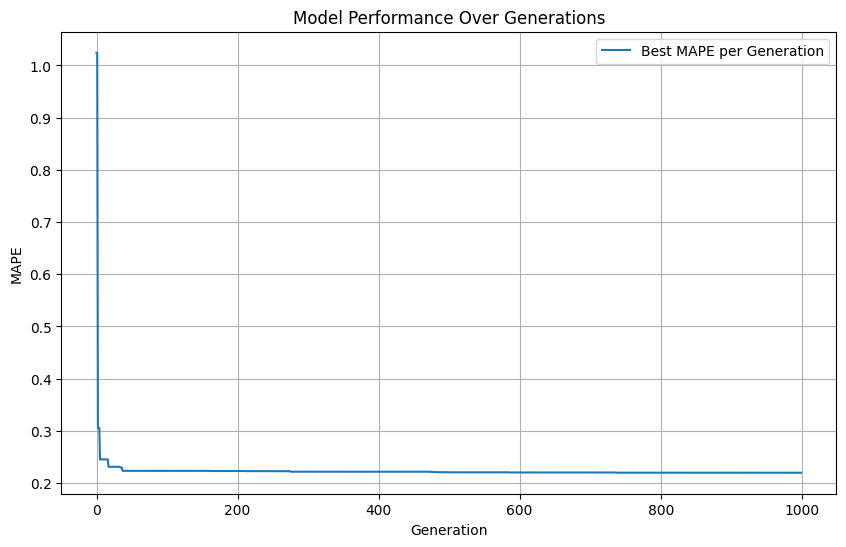

In [14]:
ga_model.plot_performance()

In [15]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_tr = model.predict(X_train)
mape_lr_tr = mean_absolute_percentage_error(y_train, y_pred_tr)
print(f"MAPE on training data: {mape_lr_tr}")
y_pred_ts = model.predict(X_test)
mape_lr_ts = mean_absolute_percentage_error(y_test, y_pred_ts)
print(f"MAPE on test data: {mape_lr_ts}")

MAPE on training data: 0.22180774828792513
MAPE on test data: 0.2817299296952579


In [16]:
inter = model.intercept_
coef = model.coef_
print(f"Optimized coefficients: {coef}")
print(f"Optimized intercept: {inter}")

Optimized coefficients: [ 0.02104605  0.02242031 -0.04770991  0.09982219 -0.06660724  0.54848013]
Optimized intercept: 120568.79070395764


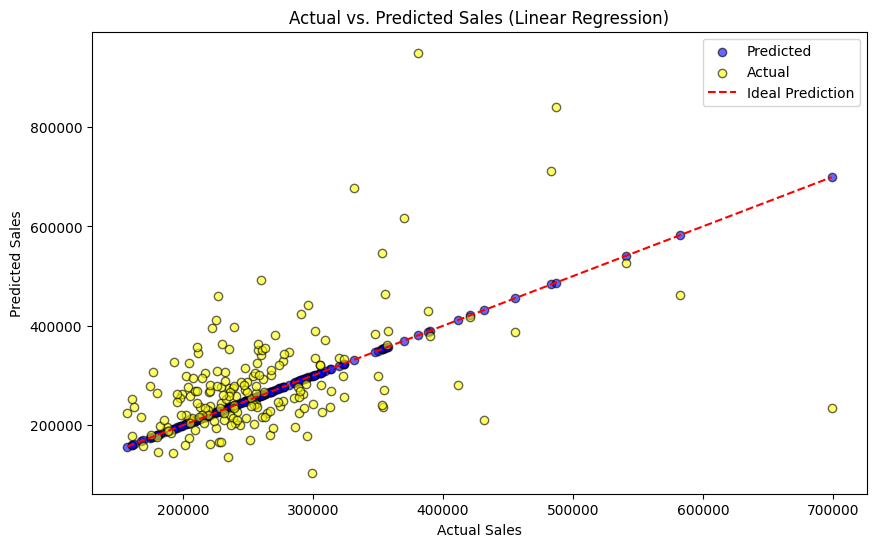

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_GA, y_pred_GA, color='blue', label='Predicted', alpha=0.6, edgecolors='k')
plt.scatter(y_pred_GA, y_train, color='yellow', label='Actual', alpha=0.6, edgecolors='k')

plt.plot([min(y_pred_GA), max(y_pred_GA)], [min(y_pred_GA), max(y_pred_GA)], color='red', linestyle='--', label='Ideal Prediction')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales (Linear Regression)')
plt.legend()
plt.show()

# Forecasting with best params

In [32]:
# Memilih data input awal untuk forecasting
X_last = df['Sale'].values[-6:]
X_last

array([165445, 237814, 308632, 255651, 284303, 155899])

In [ ]:
predictions = []
X_input = X_last.copy()

for i in range(21):
    print(f'Data Training :',{i+1})
    print(X_input)
    y_preds = X_input.dot(coefficients) + intercept
    predictions.append(y_preds)
    print(f'prediksi hari ke- :',{i+1})
    print(y_preds)
    X_input = np.roll(X_input, -1)
    print(f'Data training putar :',{i+1})
    print(X_input)
    X_input[-1] = y_preds
    print(f'Data training untuk :',{i+2})
    print(X_input)

print("Predictions for the next 21 days:", predictions)


Data Training : {1}
[165445 237814 308632 255651 284303 155899]
prediksi hari ke- : {1}
172675.24105267946
Data training putar : {1}
[237814 308632 255651 284303 155899 165445]
Data training untuk : {2}
[237814 308632 255651 284303 155899 172675]
Data Training : {2}
[237814 308632 255651 284303 155899 172675]
prediksi hari ke- : {2}
181941.69338463893
Data training putar : {2}
[308632 255651 284303 155899 172675 237814]
Data training untuk : {3}
[308632 255651 284303 155899 172675 181941]
Data Training : {3}
[308632 255651 284303 155899 172675 181941]
prediksi hari ke- : {3}
195259.84686317836
Data training putar : {3}
[255651 284303 155899 172675 181941 308632]
Data training untuk : {4}
[255651 284303 155899 172675 181941 195259]
Data Training : {4}
[255651 284303 155899 172675 181941 195259]
prediksi hari ke- : {4}
180580.17726295465
Data training putar : {4}
[284303 155899 172675 181941 195259 255651]
Data training untuk : {5}
[284303 155899 172675 181941 195259 180580]
Data Trainin

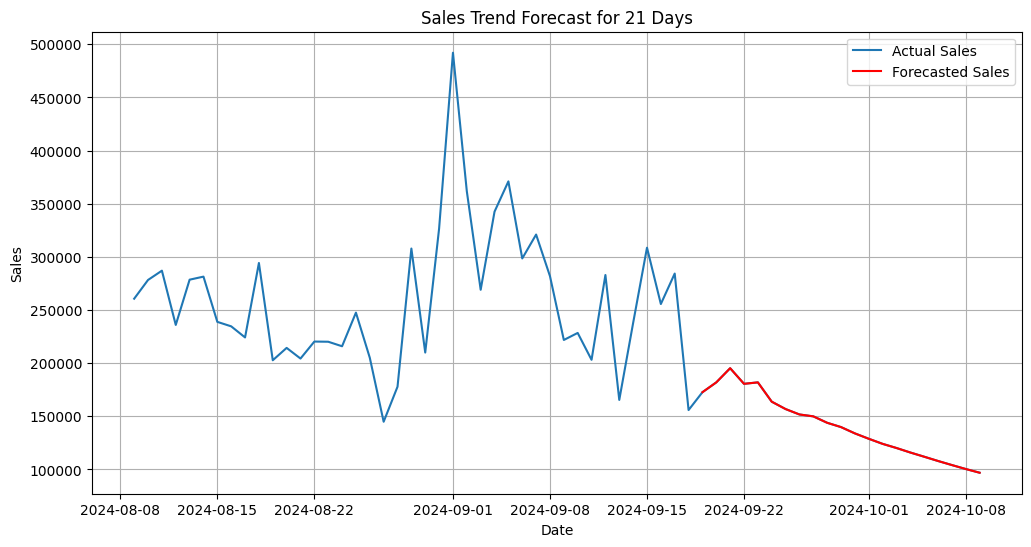

In [ ]:
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.DateOffset(days=1), periods=21)
future_sales = predictions[:21]
future_df = pd.DataFrame({'Date': future_dates, 'Sale': future_sales})

df_with_predictions = pd.concat([df, future_df], ignore_index=True)

last_2_months_data = df_with_predictions[df_with_predictions['Date'] >= df_with_predictions['Date'].max() - pd.DateOffset(months=2)]

plt.figure(figsize=(12, 6))
plt.plot(last_2_months_data['Date'], last_2_months_data['Sale'], label='Actual Sales')
plt.plot(future_df['Date'], future_df['Sale'], label='Forecasted Sales', linestyle='-', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Trend Forecast for 21 Days')
plt.legend()
plt.grid(True)
plt.show()